# Assignment 2: Rakhat Yskak(SE-2108)

Content Table:
1. Importing
2. Preprocessing
2. CNN

## Importing:

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing
from scipy import signal
import os #for import
import random
import matplotlib.pyplot as plt # data ploting
import cv2 #processing images

importing image labels and paths

In [37]:
path = '/kaggle/input/agricultural-crops-image-classification/Agricultural-crops'
classes = sorted(os.listdir(path), key=lambda s: s.lower()) #import class folders and sort ingoring case
image_paths = [] #store paths
labels = [] #store labels

for c in classes:
    class_folder = path + "/" + c #for each class define path
    for image in os.listdir(class_folder): 
        image_path = class_folder + "/" + image #for each image add to dataframe by path and label, i.e class
        image_paths.append(image_path)
        labels.append(c)

class_labels = np.unique(labels) #class labels
num_classes = len(class_labels)
label_mapping = {label: i for i, label in enumerate(class_labels)} # map labels to numerical values

print(label_mapping)

labels = np.array([label_mapping[label] for label in labels]) #change from string to index from mapping

image_paths = np.array(image_paths) #convert to numpy array

df = pd.DataFrame({"image_paths":image_paths,"labels":labels}) #create dataframe

image_paths = df['image_paths']

{'Cherry': 0, 'Coffee-plant': 1, 'Cucumber': 2, 'Fox_nut(Makhana)': 3, 'Lemon': 4, 'Olive-tree': 5, 'Pearl_millet(bajra)': 6, 'Tobacco-plant': 7, 'almond': 8, 'banana': 9, 'cardamom': 10, 'chilli': 11, 'clove': 12, 'coconut': 13, 'cotton': 14, 'gram': 15, 'jowar': 16, 'jute': 17, 'maize': 18, 'mustard-oil': 19, 'papaya': 20, 'pineapple': 21, 'rice': 22, 'soyabean': 23, 'sugarcane': 24, 'sunflower': 25, 'tea': 26, 'tomato': 27, 'vigna-radiati(Mung)': 28, 'wheat': 29}


## Preprocessing

In [38]:
def preprocess_image(image_path, target_size=(224, 224)): #This function will help to convert images into datasets
    try:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        
        # Resize the image to the target size
        image = cv2.resize(image, target_size)
        # Changing type for further changes
        image = image.astype(np.float128) / 255.0
        return image
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        return None

In [39]:
def get_image(image): #redraw image
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

In [40]:
image_size = 32 # size of image
images=[] #store processed images
for image_path in image_paths:
    image=preprocess_image(image_path, (image_size, image_size))
    images.append(image)
images = np.array(images) #convert to numpy array
images = np.transpose(images, (0, 3, 1, 2))

In [41]:
images.shape

(829, 3, 32, 32)

### Normalization

In [42]:
images -= np.mean(images, axis=0) #zero-center

In [43]:
images /= np.std(images, axis=0) #normalize by standart deviation

### Dividing data into test, train and validation
- 10% test set
- 90% trian and validation

In [44]:
def train_test_split(images, labels, test_size=0.1, num_rep=1, rand=True, strat=True):
    num_samples = images.shape[0]
    num_test = int(test_size * num_samples)
    indices = list(range(num_samples)) #indices of each image

    class_indices = [np.where(labels == c)[0] for c in range(num_classes)]
    # will return arrays of indices corrisponding to it's unique class
    
    # Initialize test_indices and train_indices lists
    test_indices = []
    train_indices = []
    
    # for function with number of repeitions to randomize our training and test sets
    for _ in range(num_rep):
        if strat:
            if rand:
                # permutates indices in each class(subarray)
                class_indices = [np.random.permutation(class_ids) for class_ids in class_indices]
            
            # Calculate the number of samples from each class for testing
            num_samples_per_class_test = [int(len(class_ids) * test_size) for class_ids in class_indices]

            for i, class_ids in enumerate(class_indices):
                test_indices.extend(class_ids[:num_samples_per_class_test[i]])
                train_indices.extend(class_ids[num_samples_per_class_test[i]:])
            
            # Shuffle the test and train indices if rand is True
            if rand:
                random.shuffle(test_indices)
                random.shuffle(train_indices)
        else:
            if rand:
                # Shuffle the indices randomly
                indices = np.random.permutation(num_samples)
            # Split the indices into training and testing sets
            
            test_indices = indices[:num_test]
            train_indices = indices[num_test:]
            
        if not rand: 
            break
            
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_samples, num_classes, 1))
    for i in range(num_samples):
        one_hot_labels[i, labels[i]] = 1
    # Create the training and testing sets
    Xtr, Ytr = images[train_indices], one_hot_labels[train_indices]
    Xte, Yte = images[test_indices], one_hot_labels[test_indices]

    return Xtr, Xte, Ytr, Yte

# Convolutional Neural Network

I decided to implement some OOP concepts

Here is my layer abstact class that will be implemented by other layers

In [45]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [46]:
class Convolutional(Layer):
    def __init__(self, input_shape, filter_size, num_filters, weight_initialization):
        super.__init__
        input_depth, input_height, input_width = input_shape
        self.num_filters = num_filters
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (num_filters, input_height - filter_size + 1, input_width - filter_size + 1)
        self.filters_shape = (num_filters, input_depth, filter_size, filter_size)
        self.filters = weight_initialization(self.filters_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.num_filters):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.filters[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        filters_gradient = np.zeros(self.filters_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.num_filters):
            for j in range(self.input_depth):
                filters_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.filters[i, j], "full")

        self.filters -= learning_rate * filters_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

Conv Layer:

Accepts a volume of size W1×H1×D1
- Requires four hyperparameters:
    - Number of filters K,
    - their spatial extent F,
    - the stride S,
    - the amount of zero padding P.
- Produces a volume of size W2×H2×D2 where:
    - W2=(W1−F+2P)/S+1
    - H2=(H1−F+2P)/S+1 (i.e. width and height are computed equally by symmetry) 
    - D2=K
- With parameter sharing, it introduces F⋅F⋅D1 weights per filter, for a total of (F⋅F⋅D1)⋅K weights and K biases.
- In the output volume, the d-th depth slice (of size W2×H2) is the result of performing a valid convolution of the d-th filter over the input volume with a stride of S, and then offset by d-th bias.

**Why use stride of 1 in CONV? Smaller strides work better in practice. Additionally, as already mentioned stride 1 allows us to leave all spatial down-sampling to the POOL layers, with the CONV layers only transforming the input volume depth-wise.**

## Pooling Layer

In [47]:
class Pool(Layer):
    def __init__(self, input_shape, filter_size=2, stride=2):
        input_depth, input_height, input_width = input_shape
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.filter_size = filter_size
        self.stride = stride
        self.output_shape = (input_depth, int((input_height - filter_size) / stride + 1), int((input_width - filter_size) / stride + 1))
        
    def forward(self, input):
        self.input = input
        self.output = np.zeros(self.output_shape)
        for d in range(self.input_depth):
            for i in range(0, self.input_shape[1] - self.filter_size + 1, self.stride):
                for j in range(0, self.input_shape[2] - self.filter_size + 1, self.stride):
                    window = self.input[d, i:i+self.filter_size, j:j+self.filter_size]
                    self.output[d, i//self.stride, j//self.stride] = np.max(window)

        return self.output

    def backward(self, output_gradient, learning_rate):
        # TODO implement
        input_gradient = np.zeros(self.input_shape)

        for d in range(self.input_depth):
            for i in range(0, self.input_shape[1] - self.filter_size + 1, self.stride):
                for j in range(0, self.input_shape[2] - self.filter_size + 1, self.stride):
                    window = self.input[d, i:i+self.filter_size, j:j+self.filter_size]
                    max_val = np.max(window)
                    mask = (window == max_val)
                    input_gradient[d, i:i+self.filter_size, j:j+self.filter_size] += mask * output_gradient[d, i//self.stride, j//self.stride]

        return input_gradient
        

## Activation Layer:

In [48]:
class Activation(Layer):
    def __init__(self, activation, d_activation):
        self.activation = activation
        self.d_activation = d_activation

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return self.output

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.d_activation(self.input))

activations:
- Sigmoid
- ReLU

In [49]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def d_sigmoid(x):
            s = sigmoid(x)
            return s * (1 - s)
        super().__init__(sigmoid, d_sigmoid)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(x, 0)

        def d_relu(x):
            return np.array(x > 0).astype('int')
        super().__init__(relu, d_relu)

class Softmax(Layer):
    def forward(self, input):
        self.input = input
        self.input -= np.max(self.input)
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

## Fully Connected layer

In [50]:
## Fully connected
class FullyConnected(Layer):
    def __init__(self, input_size, output_size, weight_initialization):
        self.weights = weight_initialization((output_size, input_size))
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        self.output = np.dot(self.weights, self.input) + self.bias
        return self.output

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [51]:
# layer that helps to reshape layers for fullyconnected
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        self.input = input
        self.output = np.reshape(input, self.output_shape)
        return self.output

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

## Weight Initialization

here is weight initilization functions

In [52]:
small_random_for_ReLU = lambda x: np.random.randn(*x) / np.sqrt(2 / np.sum(x))
small_random = lambda x: np.random.randn(*x)
xavier = lambda x: np.random.normal(0, np.sqrt(2.0 / (x[0] + x[1])), size=x)

initilizeing W from cs2321n

w = np.random.randn(n) / sqrt(n) common variant

w = np.random.randn(n) / sqrt(2/n) for ReLu works better

## Loss function

In [53]:
class Loss:
    def call(self, y_true, y_pred):
        raise NotImplementedError

    def prime(self, y_true, y_pred):
        raise NotImplementedError

In [54]:
class MSE(Loss):
    def call(self, y_pred, y_true):
        return np.mean(np.power(y_true - y_pred, 2))

    def prime(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_pred.size

## Dropout

Inverted Dropout: Recommended implementation example.

We drop and scale at train time and don't do anything at test time.

In [55]:
class Dropout(Layer):
    def __init__(self, p=0.1):
        self.p = p
        self.mask = None

    def forward(self, input):
        self.input = input
        self.mask = np.random.rand(*self.input.shape) < self.p
        self.output = np.copy(input)
        self.output[self.mask] = 0
        return self.output

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.ones(self.input.shape)
        input_gradient[self.mask] = 0
        return input_gradient

## Batch Normaliztion

In [58]:
class BatchNormalization(Layer):
    def __init__(self, epsilon=0.001):
        super().__init__()
        self.epsilon = epsilon
        self.gamma = 0.09
        self.beta = 0.09

    def forward(self, input):
        self.input = input
        self.mean = np.mean(input)
        self.var = np.var(input)
        self.inputbar = (input - self.mean) / np.sqrt(self.var + self.epsilon)
        self.output = self.gamma * self.inputbar + self.beta
        return self.output

    def backward(self, output_gradient, learning_rate):
        N = self.input.size
        dinputbar = output_gradient * self.gamma
        tmp = N * np.sqrt(self.var + self.epsilon)
        input_gradient = (N * dinputbar - np.sum(dinputbar, axis=0) - self.inputbar * np.sum(dinputbar * self.inputbar, axis=0)) / tmp
        self.gamma += np.sum(output_gradient * self.inputbar, axis=0)
        self.beta += np.sum(output_gradient, axis=0)
        return input_gradient

## predict and train functions

In [59]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    train_set_size = len(x_train)
    mode = "train"
    loss_history = []
    for epoch in range(1, epochs + 1):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)
            #print(output.shape)
            
            # error
            error += loss.call(y, output)
            
            # backward
            grad = loss.prime(y, output)
            
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)
                
        error /= train_set_size
        loss_history.append(error)
        if verbose:
            print('%d/%d, error=%f' % (epoch, epochs, error))
    plt.plot(loss_history)
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    

def test(network, loss, x_test, y_test):
    error = 0
    for x, y in zip(x_test, y_test):
        output = predict(network, x)
        error += loss.call(y, output)
    error /= len(x_test)
    return error

In [ ]:
def get_accuracy(X, Y, network):
    # test
    correct_predictions = 0
    total_predictions = len(X)

    for x, y in zip(X, Y):
        predicted_class = np.argmax(predict(network, x))
        true_class = np.argmax(y)

        if predicted_class == true_class:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [60]:
Xtr, Xte, Ytr, Yte = train_test_split(images, labels, 0.1) # (10%) x (image_size * image_size * 3)

The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size.

> INPUT -> ((CONV -> RELU) * N -> POOL?)*M -> (FC -> RELU)*K -> FC

I will choose:
- N = 1
- M = 2
- K = 1

1/20, error=0.059459
2/20, error=0.064280
3/20, error=0.064355
4/20, error=0.064413
5/20, error=0.064057
6/20, error=0.063990
7/20, error=0.064241
8/20, error=0.063971
9/20, error=0.064310
10/20, error=0.064281
11/20, error=0.063748
12/20, error=0.064461
13/20, error=0.064156
14/20, error=0.063710
15/20, error=0.064253
16/20, error=0.064256
17/20, error=0.063827
18/20, error=0.064083
19/20, error=0.064033
20/20, error=0.064000


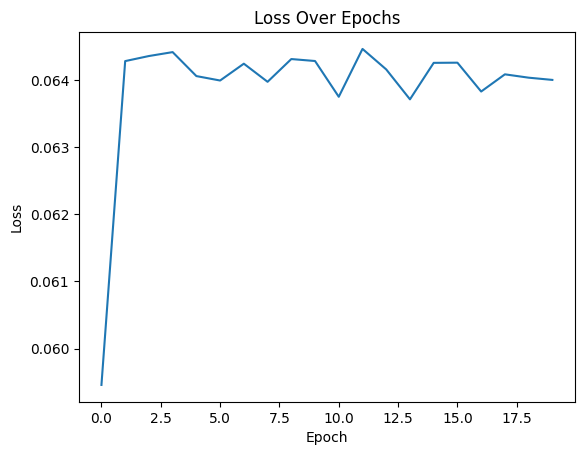

In [65]:
network_relu_1 = [
    Convolutional((3, 32, 32), 3, 5, small_random_for_ReLU),
    ReLU(),
    Pool((5, 30, 30)),
    Convolutional((5, 15, 15), 2, 7, small_random_for_ReLU),
    ReLU(),
    Pool((7, 14, 14)),
    Reshape((7, 7, 7), (7*7*7, 1)),
    FullyConnected(7*7*7, num_classes, small_random_for_ReLU),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),
    Softmax(),
]

# train
train(
    network_relu_1,
    MSE(),
    Xtr,
    Ytr,
    epochs=20,
    learning_rate=0.1
)

In [66]:
test(network_relu_1, MSE(), Xte, Yte)

0.06388886744769105

In [73]:
get_accuracy(Xte, Yte, network_relu_1)

0.027777777777777776

1/20, error=0.032219
2/20, error=0.032284
3/20, error=0.032270
4/20, error=0.032270
5/20, error=0.032279
6/20, error=0.032282
7/20, error=0.032236
8/20, error=0.032265
9/20, error=0.032243
10/20, error=0.032281
11/20, error=0.032268
12/20, error=0.032275
13/20, error=0.032269
14/20, error=0.032249
15/20, error=0.032260
16/20, error=0.032263
17/20, error=0.032287
18/20, error=0.032256
19/20, error=0.032263
20/20, error=0.032297


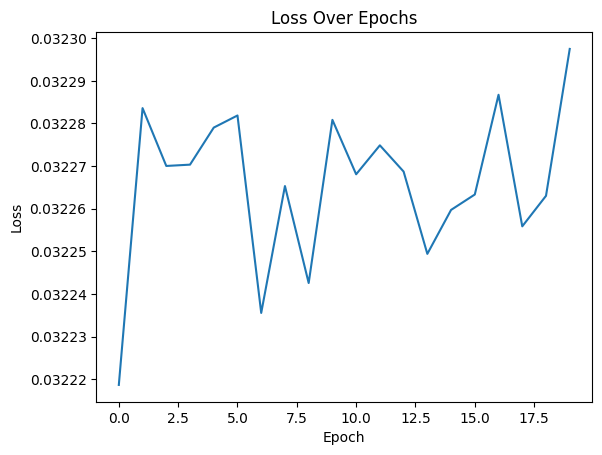

In [75]:
network_sigmoid_1 = [
    Convolutional((3, 32, 32), 3, 5, small_random),
    Sigmoid(),
    Pool((5, 30, 30)),
    Convolutional((5, 15, 15), 2, 3, small_random),
    Sigmoid(),
    Pool((3, 14, 14)),
    Reshape((3, 7, 7), (3*7*7, 1)),
    FullyConnected(3*7*7, num_classes, small_random),
    BatchNormalization(),
    Sigmoid(),
    Dropout(),
    Softmax(),
]

# train
train(
    network_sigmoid_1,
    MSE(),
    Xtr,
    Ytr,
    epochs=20,
    learning_rate=0.01
)

1/20, error=0.466500
2/20, error=0.307341
3/20, error=0.263217
4/20, error=0.220584
5/20, error=0.186074
6/20, error=0.156856
7/20, error=0.132808
8/20, error=0.127294
9/20, error=0.101687
10/20, error=0.076694
11/20, error=0.063299
12/20, error=0.055488
13/20, error=0.050516
14/20, error=0.047121
15/20, error=0.044677
16/20, error=0.042844
17/20, error=0.041426
18/20, error=0.040299
19/20, error=0.039386
20/20, error=0.038633


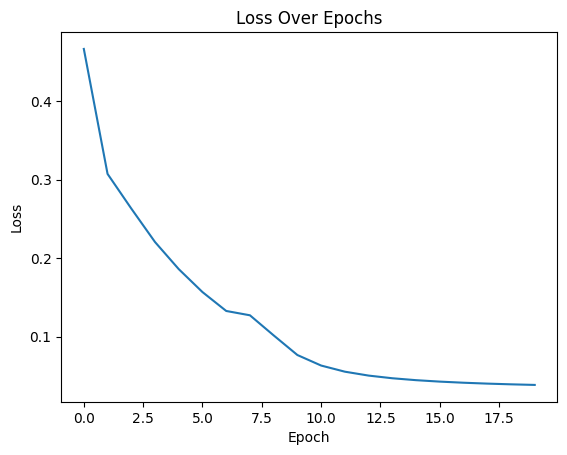

In [84]:
network_relu_2 = [
    Convolutional((3, 32, 32), 5, 5, small_random_for_ReLU),
    ReLU(),
    Pool((5, 28, 28)),
    Reshape((5, 14, 14), (5*14*14, 1)),
    FullyConnected(5*14*14, 100, small_random_for_ReLU),
    BatchNormalization(),
    ReLU(),
    FullyConnected(100, num_classes, small_random),
    Sigmoid()
]

# train
train(
    network_relu_2,
    MSE(),
    Xtr,
    Ytr,
    epochs=20,
    learning_rate=0.1
)

In [86]:
get_accuracy(Xte, Yte, network_relu_2)

0.027777777777777776

1/20, error=0.092717
2/20, error=0.053672
3/20, error=0.031889
4/20, error=0.031075
5/20, error=0.030109
6/20, error=0.029036
7/20, error=0.027836
8/20, error=0.026434
9/20, error=0.024905
10/20, error=0.023312
11/20, error=0.021643
12/20, error=0.020007
13/20, error=0.018423
14/20, error=0.016977
15/20, error=0.015656
16/20, error=0.014385
17/20, error=0.013233
18/20, error=0.012258
19/20, error=0.011435
20/20, error=0.010734


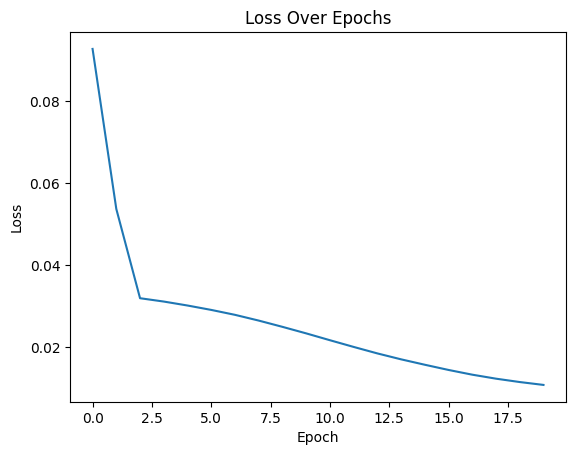

In [85]:
network_bare_sigmoid = [
    Convolutional((3, 32, 32), 3, 5, xavier),
    Sigmoid(),
    Reshape((5, 30, 30), (5 * 30 * 30, 1)),
    FullyConnected(5 * 30 * 30, 100, xavier),
    Sigmoid(),
    FullyConnected(100, num_classes, small_random),
    Sigmoid()
]

# train
train(
    network_bare_sigmoid,
    MSE(),
    Xtr,
    Ytr,
    epochs=20,
    learning_rate=0.1
)

In [87]:
get_accuracy(Xte, Yte, network_bare_sigmoid)

0.2777777777777778

we can clearly see that previous nets are over killing the data there fore there is no learning data is to small